<a href="https://colab.research.google.com/github/connect-midhunr/rossmann-sales-prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Business Task

Build a machine learning model to forecast the sales of each Rossmann store upto 6 weeks. This is undertaken as an individual project.

# Importing Libraries and Defining Functions

In [1]:
# importing all relevant python libraries

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# define a fubction to find the number and percentage of missing values in a dataframe
def get_missing_values_count_and_percentage(dataframe):
  num = 0
  for column in dataframe.columns:
    count = dataframe[column].isnull().sum()
    percentage = count/dataframe.shape[0]*100
    if percentage > 0:
      num += 1
      print(f"{column}: {count}({round(percentage, 2)})%")
  if num == 0:
    print("No missing values in the dataframe")

In [3]:
# define a function to calculate the upper and lower outlier boundary
# returns a tuple (upper_outlier_bound, lower_outlier_bound)
def get_outlier_boundaries(dataframe, column):
  percentile_25 = np.nanpercentile(dataframe[column],25)
  percentile_75 = np.nanpercentile(dataframe[column],75)
  iqr = (percentile_75 - percentile_25)
  upper_outlier_bound = percentile_75 + 1.5*iqr
  lower_outlier_bound = percentile_25 - 1.5*iqr

  return (upper_outlier_bound, lower_outlier_bound)

# define a function to calculate the number and percentage of outliers in a column
# returns a tuple (count, percentage)
def get_outlier_count_and_percentage(dataframe, column):
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)

  count = 0
  for value in dataframe[column]:
    if value > upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = count/store_df.shape[0]*100

  return (count, percentage)

# define a function to remove outlier
# returns a dataframe
def get_outliers_removed(dataframe, column):
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)
  ind = dataframe[(dataframe[column] >= upper_outlier_bound) & (dataframe[column] <= lower_outlier_bound)].index
  # temp_df = dataframe[(dataframe[column] <= upper_outlier_bound) and (dataframe[column] >= lower_outlier_bound)]
  dataframe.drop(ind, inplace=True)

  return dataframe

In [4]:
# define a function to get count of each unique value from a particular column 
# returns a dataframe
def get_count_from_column(dataframe, column_label):
  df_grpd = dataframe[column_label].value_counts()
  df_grpd = pd.DataFrame({'index':df_grpd.index, 'count':df_grpd.values})
  return df_grpd

# define a function to get sum of a certain feature for each unique value from a particular column 
# returns a dataframe
def get_sum_from_column(dataframe, column_label, feature):
  df_grpd = dataframe.groupby(column_label)[feature].sum().reset_index(name=feature)
  return df_grpd

# define a function to get average of a certain feature for each unique value from a particular column 
# returns a dataframe
def get_avg_from_column(dataframe, column_label, feature):
  df_grpd = dataframe.groupby(column_label)[feature].mean().reset_index(name=feature)
  return df_grpd

In [5]:
# define a function to generate horizontal box plot
# prints a box plot
def generate_horizontal_box_plot(dataframe, column):
  sns.set_theme(rc={'figure.figsize': (8,4)},style='whitegrid',palette='muted')
  ax = sns.boxplot(x=dataframe[column])
  ax.grid(False)

# define a function to generate vertical box plot
# prints a box plot
def generate_vertical_box_plot(dataframe, column):
  sns.set_theme(rc={'figure.figsize': (4,8)},style='whitegrid',palette='muted')
  ax = sns.boxplot(y=dataframe[column])
  ax.grid(False)

In [47]:
# define a function to plot a pie chart
def plot_pie_chart_from_column(dataframe, x_feature, y_feature):
  fig, ax = plt.subplots(figsize=(14, 6))
  ax.pie(dataframe.loc[:, x_feature], labels=dataframe.loc[:, y_feature], autopct='%1.2f%%', startangle=90)
  ax.axis('equal')
  plt.show()

# define a function to plot a pie chart from grouped data
def plot_pie_chart_from_column_count(dataframe, column_label):
  df_grpd = get_count_from_column(dataframe, column_label)
  plot_pie_chart_from_column(df_grpd, 'count', 'index')

In [65]:
# define a function to plot bar graph with two features
def plot_bar_graph_with_two_features(dataframe, x_feature, y_feature):
  if type(y_feature) == list:
    size = len(y_feature)
    fig, axes = plt.subplots(1, size, figsize=(10*size, 6))
    num = -1
    for feature in y_feature:
      num += 1
      sns.barplot(ax=axes[num], x=dataframe[x_feature], y=dataframe[feature], estimator=sum)
      axes[num].set_title(f"Sum of {feature} vs {x_feature}")
  else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=dataframe[x_feature], y=dataframe[y_feature], estimator=sum)
    ax.set_title(f"Sum of {y_feature} vs {x_feature}")
    plt.show()

In [8]:
# define a function to plot line graph with dot markers
def plot_line_graph_with_two_features(dataframe, x_feature, y_feature):
  temp_df = get_outliers_removed(dataframe, y_feature)
  temp_df = dataframe.copy().groupby(x_feature)[y_feature].sum().reset_index(name=y_feature)

  plt.figure(figsize=(12, 6))
  plt.plot(temp_df[x_feature], temp_df[y_feature], marker='o')
  plt.xlabel(x_feature)
  plt.ylabel(y_feature)
  plt.xticks(rotation='horizontal')
  plt.show()

# Data Reading

In [9]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# creating dataframes and store csv data

sales_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Supervised Machine Learning - Regression/Rossmann Sales Prediction - Midhun R/Data & Resources/Rossmann Stores Data.csv')
store_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Supervised Machine Learning - Regression/Rossmann Sales Prediction - Midhun R/Data & Resources/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Pre-processing

## Data Inspection

Two datasets are given: store data and sales data. These two datasets should be merged after data cleaning.

### Store Data

In [11]:
# exploring the head of the store dataframe

store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# exploring the tail of store dataframe

store_df.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [13]:
# looking into a brief summary of store dataframe

store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [14]:
# total number of rows in store dataframe
num_of_rows = store_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = store_df[store_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1115
No. of duplicate rows: 0


*   Store dataframe contains 1115 rows of data and has zero duplicate rows.

In [15]:
# exploring the columns of store dataframe

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


*   Store dataframe contains 10 columns.
*   Six columns have missing values.
*   Some columns require conversion of datatypes. 
*   Additionally, new columns need to be added from existing ones to make analysis easier.

In [16]:
# unique values in each column of store dataframe

print(store_df.apply(lambda col: col.unique()))

Store                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
StoreType                                                         [c, a, d, b]
Assortment                                                           [a, c, b]
CompetitionDistance          [1270.0, 570.0, 14130.0, 620.0, 29910.0, 310.0...
CompetitionOpenSinceMonth    [9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6....
CompetitionOpenSinceYear     [2008.0, 2007.0, 2006.0, 2009.0, 2015.0, 2013....
Promo2                                                                  [0, 1]
Promo2SinceWeek              [nan, 13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0,...
Promo2SinceYear              [nan, 2010.0, 2011.0, 2012.0, 2009.0, 2014.0, ...
PromoInterval                [nan, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Ju...
dtype: object


### Sales Data

In [17]:
# exploring the head of the sales dataframe

sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [18]:
# exploring the tail of sales dataframe

sales_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [19]:
# looking into a brief summary of sales dataframe

sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [20]:
# total number of rows in sales dataframe
num_of_rows = sales_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = sales_df[sales_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1017209
No. of duplicate rows: 0


*   Sales dataframe contains 1017209 rows of data and has zero duplicate rows.

In [21]:
# exploring the columns of sales dataframe

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


*   Sales dataframe contains 9 columns.
*   No columns have missing values.
*   Some columns require conversion of datatypes. 

In [22]:
# unique values in each column of sales dataframe

print(sales_df.apply(lambda col: col.unique()))

Store            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
DayOfWeek                                    [5, 4, 3, 2, 1, 7, 6]
Date             [2015-07-31, 2015-07-30, 2015-07-29, 2015-07-2...
Sales            [5263, 6064, 8314, 13995, 4822, 5651, 15344, 8...
Customers        [555, 625, 821, 1498, 559, 589, 1414, 833, 687...
Open                                                        [1, 0]
Promo                                                       [1, 0]
StateHoliday                                       [0, a, b, c, 0]
SchoolHoliday                                               [1, 0]
dtype: object


## Data Cleaning

### Handle Missing Values

Six out of 10 columns in store data have missing values in them. They must be handled properly inorder to get an accurate result.

In [23]:
# finding the number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

CompetitionDistance: 3(0.27)%
CompetitionOpenSinceMonth: 354(31.75)%
CompetitionOpenSinceYear: 354(31.75)%
Promo2SinceWeek: 544(48.79)%
Promo2SinceYear: 544(48.79)%
PromoInterval: 544(48.79)%


Number of outliers: 108
Percentage of outliers: 9.686098654708521%


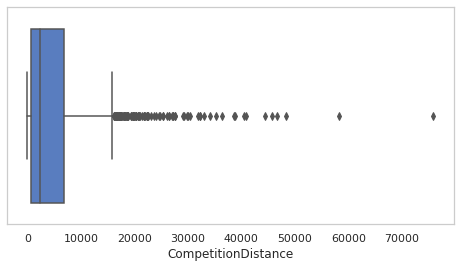

In [24]:
# create a box plot to show the distribution of values in CompetitionDistance

generate_horizontal_box_plot(store_df, "CompetitionDistance")
outlier_count_CompetitionDistance, outlier_percentage_CompetitionDistance = get_outlier_count_and_percentage(store_df, "CompetitionDistance")
print(f"Number of outliers: {outlier_count_CompetitionDistance}")
print(f"Percentage of outliers: {outlier_percentage_CompetitionDistance}%")

Due to the presence of outliers, mode and median are more appropriate for imputing missing values than mean. We can go ahead with median.

In [25]:
# filling the missing values with median
store_df["CompetitionDistance"].fillna(value = store_df.CompetitionDistance.median(), inplace=True)

Both CompetitionOpenSinceMonth and CompetitionOpenSinceYear have the same number of missing values. This may mean that both the features have missing values in the same rows.

In [26]:
# check if CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["CompetitionOpenSinceMonth"]) and np.isnan(row["CompetitionOpenSinceYear"]):
    count += 1

print(count)

354


So, both the features have missing values in the same rows. Now lets check if its related to CompetitionDistance.

In [27]:
# show CompetitionDistance, CompetitionOpenSinceMonth and CompetitionOpenSinceYear for rows
# where CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values

store_df[np.isnan(store_df["CompetitionOpenSinceMonth"])].loc[:, ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
11,1070.0,NaN,NaN
12,310.0,NaN,NaN
15,3270.0,NaN,NaN
18,3240.0,NaN,NaN
21,1040.0,NaN,NaN
...,...,...,...
1095,1130.0,NaN,NaN
1099,540.0,NaN,NaN
1112,9260.0,NaN,NaN
1113,870.0,NaN,NaN


Since we didn't get any relevant information from the above process, lets impute missing values with most frequent values.

In [28]:
# filling the missing values with mode
store_df["CompetitionOpenSinceMonth"].fillna(value = store_df.CompetitionDistance.mode()[0], inplace=True)
store_df["CompetitionOpenSinceYear"].fillna(value = store_df.CompetitionDistance.mode()[0], inplace=True)

Promo2SinceWeek, Promo2SinceYear and PromoInterval have the same number of missing values. This may mean that these features have missing values in the same rows.

In [29]:
# check if Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["Promo2SinceWeek"]) and np.isnan(row["Promo2SinceYear"]) and np.isnan(row["PromoInterval"]):
    count += 1

print(count)

544


So, these features have missing values in the same rows. Now lets check if its related to Promo2.

In [30]:
# show Promo2, Promo2SinceWeek, Promo2SinceYear and PromoInterval for rows
# where Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values

store_df[np.isnan(store_df["Promo2SinceWeek"])].loc[:, ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
...,...,...,...,...
1107,0,NaN,NaN,NaN
1109,0,NaN,NaN,NaN
1111,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN


Promo2 value of head and tail of the above dataframe is 0. Lets check whether missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2.

In [31]:
# show the count of each unique value in Promo2
store_df["Promo2"].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

So, missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2. Lets impute missing values with 0.

In [32]:
# filling the missing values with value 0
store_df["Promo2SinceWeek"].fillna(value = 0, inplace=True)
store_df["Promo2SinceYear"].fillna(value = 0, inplace=True)
store_df["PromoInterval"].fillna(value = 0, inplace=True)

In [33]:
# number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

No missing values in the dataframe


### Merging Dataframes

In [34]:
# merge the two datasets on Store data
rossmann_df = sales_df.merge(right=store_df, on="Store", how="left")

In [35]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [36]:
get_missing_values_count_and_percentage(rossmann_df)

No missing values in the dataframe


### Conversion of Column Datatype

In [37]:
# datatypes of columns in merged dataframe
rossmann_df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [38]:
# date should be converted from object to datetime
rossmann_df['Date'] = pd.to_datetime(rossmann_df['Date'])

In [39]:
# unique values in StateHoliday
rossmann_df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [40]:
# convert StateHoliday values to int
rossmann_df["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)
rossmann_df["StateHoliday"].unique()

array([0, 1])

In [41]:
# convert CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear
# from float to int
rossmann_df = rossmann_df.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})

### Manipulation of Columns

In [42]:
# split the date column into month and year

rossmann_df['Month'] = rossmann_df['Date'].dt.month
rossmann_df['Year'] = rossmann_df['Date'].dt.year

In [43]:
# exploring the head of the resultant dataframe
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,0,0,0,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,0,0,0,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,0,0,0,7,2015


# Exploratory Data Analysis

## 1. Univariate Analysis

Lets find the percentage of each store type.

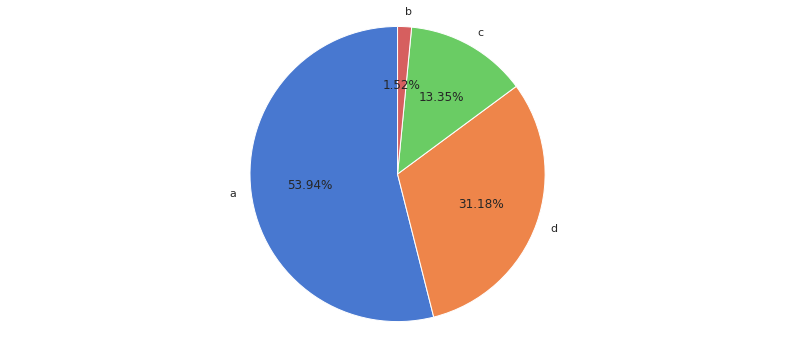

In [48]:
# plot a pie chart to show % of store types
plot_pie_chart_from_column_count(rossmann_df.copy().loc[0:1115, ['Store', 'StoreType']], 'StoreType')

Store type a is the most common store type, followed by d, c and then b. Store type a takes up the majority share of all store types.

Lets find the percentage of each assortment.

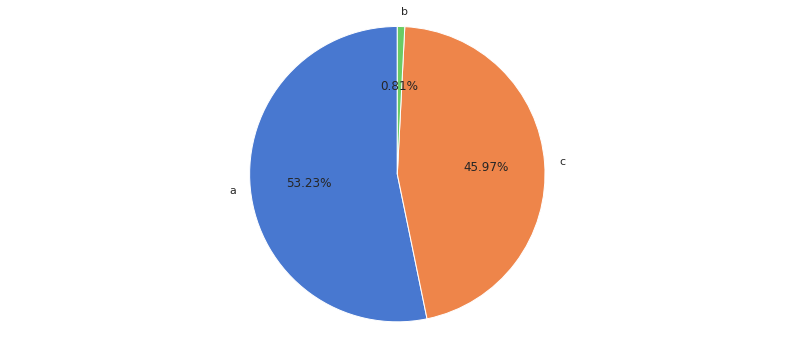

In [49]:
# plot a pie chart to show % of assortments
plot_pie_chart_from_column_count(rossmann_df.copy().loc[0:1115, ['Store', 'Assortment']], 'Assortment')

Assortment a is the most common store type, followed by c and then b. Assortment a takes up the majority share of all assortments while assortment b comprises a negligible portion of the whole.

## Bivariate Analysis

Lets check how categorical features like DayOfWeek, Open, Promo etc. affect the sales and customers.

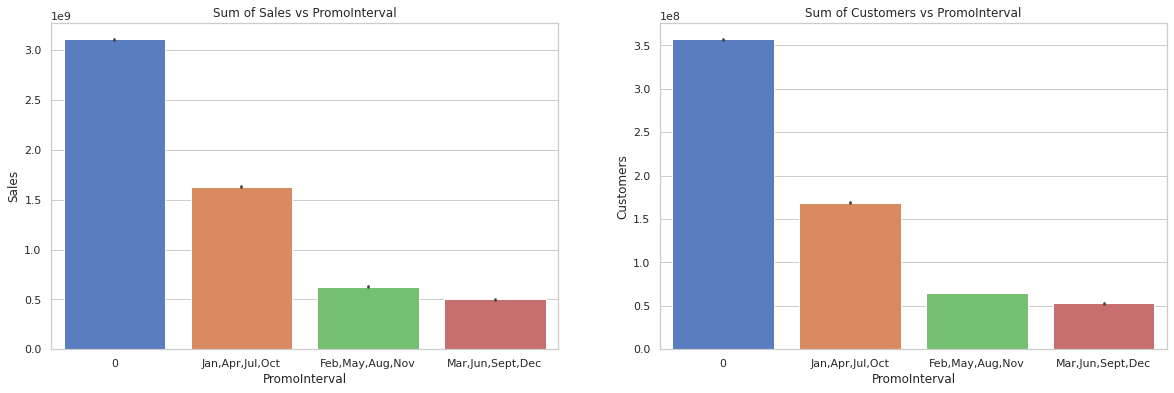

In [66]:
# categotical variables
categorical_variables = ['PromoInterval']

# plot bar graphs for each categorical variable against the sum of sales
for feature in categorical_variables:
  plot_bar_graph_with_two_features(rossmann_df, feature, ['Sales', 'Customers'])

The following observations were made from the above graphs:
*   Highest sales is recorded on Mondays and lowest sales is recorded on Sundays. This may be because most of the shops are closed on sundays and this leads to higher demand on the next day, which is Monday.
*   Presence of promos increases sales but it doesn't help much in bringing in new customers.
*   Shops are closed on all state holidays but sometimes some shops are opened during school holidays, which may be Saturdays.
*   Sales are higher on school holidays than other days.
*   Store type a records the most amount of sales and has more customers, mostly because the majority of the shops are type a.
*   Sales of assortment b is very rare and it has least customers.
*   Participants of promo 2 has less sales and customers, might be because it is seasonal and doesn't have any effect on sales and customers.
*   Promo interval Jan, Apr, Jul, Oct brings in more sales and customers.









Lets check which store type and assortment has the highest average sales and customer.

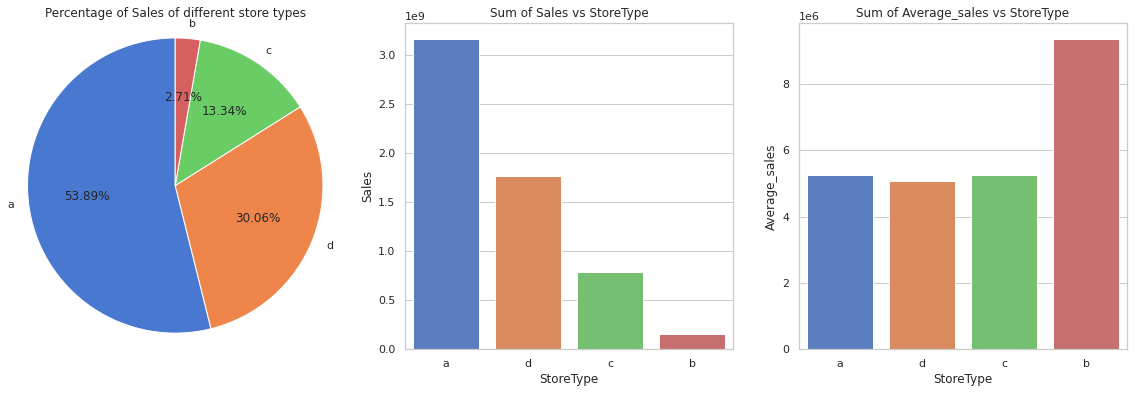

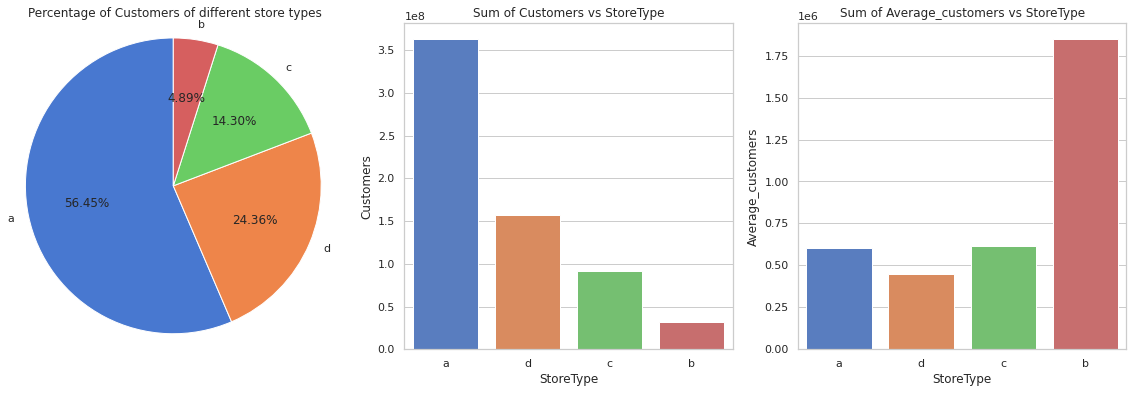

In [51]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different store types
store_type_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'StoreType']], 'StoreType').rename(columns={'index':'StoreType'})

store_type_sales_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Sales')
store_type_df = store_type_count_df.merge(right=store_type_sales_sum_df, on='StoreType')
store_type_df['Percent_sales'] = round(store_type_df['Sales']/store_type_df['Sales'].sum()*100, 2)
store_type_df['Average_sales'] = round(store_type_df['Sales']/store_type_df['count'], 2)

store_type_customer_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Customers')
store_type_df = store_type_df.merge(right=store_type_customer_sum_df, on='StoreType')
store_type_df['Percent_customers'] = round(store_type_df['Customers']/store_type_df['Customers'].sum()*100, 2)
store_type_df['Average_customers'] = round(store_type_df['Customers']/store_type_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(store_type_df.loc[:, feature], labels=store_type_df.loc[:, 'StoreType'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=store_type_df['StoreType'], y=store_type_df[feature])
  axes[1].set_title(f"Sum of {feature} vs {'StoreType'}")

  sns.barplot(ax=axes[2], x=store_type_df['StoreType'], y=store_type_df['Average_' + feature.lower()])
  axes[2].set_title(f"Sum of {'Average_' + feature.lower()} vs {'StoreType'}")

  plt.show()

Eventhough the volume of sales and customers is low, store type b has the highest average sales and customers. This means store type b is more preferred by customers.

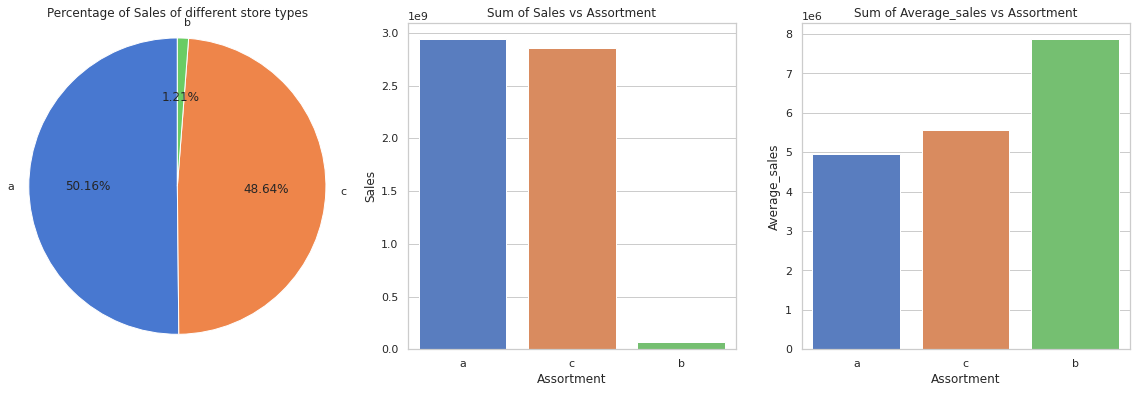

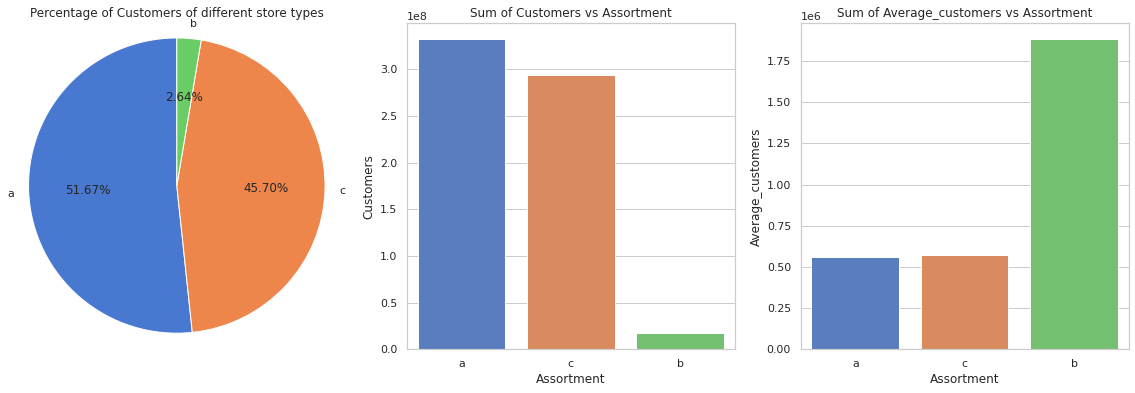

In [52]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different assortments
assortment_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'Assortment']], 'Assortment').rename(columns={'index':'Assortment'})

assortment_sales_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Sales')
assortment_df = assortment_count_df.merge(right=assortment_sales_sum_df, on='Assortment')
assortment_df['Percent_sales'] = round(assortment_df['Sales']/assortment_df['Sales'].sum()*100, 2)
assortment_df['Average_sales'] = round(assortment_df['Sales']/assortment_df['count'], 2)

assortment_customer_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Customers')
assortment_df = assortment_df.merge(right=assortment_customer_sum_df, on='Assortment')
assortment_df['Percent_customers'] = round(assortment_df['Customers']/assortment_df['Customers'].sum()*100, 2)
assortment_df['Average_customers'] = round(assortment_df['Customers']/assortment_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(assortment_df.loc[:, feature], labels=assortment_df.loc[:, 'Assortment'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=assortment_df['Assortment'], y=assortment_df[feature])
  axes[1].set_title(f"Sum of {feature} vs {'Assortment'}")

  sns.barplot(ax=axes[2], x=assortment_df['Assortment'], y=assortment_df['Average_' + feature.lower()])
  axes[2].set_title(f"Sum of {'Average_' + feature.lower()} vs {'Assortment'}")

  plt.show()

Eventhough the volume of sales and customers is low, assortment b has the highest average sales and customers. This means assortment b is in high demand.

Lets check how continous features like month, year,CompetitionOpenSinceYear, etc. affects the sales and customers.

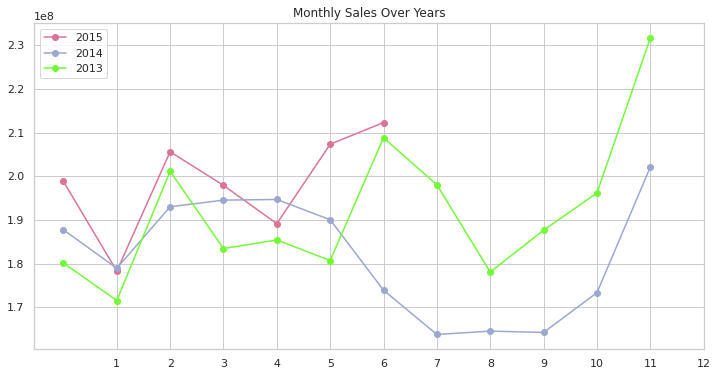

In [53]:
# unique year values in date
years = rossmann_df['Year'].unique().tolist()

num_of_colors = len(years)
list_of_colors = color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
                                                                       for j in range(num_of_colors)]
num = -1
plt.figure(figsize=(12, 6))
for year in years:
  num += 1
  temp_df = rossmann_df[rossmann_df['Year'] == year]
  temp_df = temp_df.groupby('Month')['Sales'].sum().reset_index()
  plt.plot(temp_df.loc[:,'Sales'], label=year, color=list_of_colors[num], marker='o')
  plt.xticks(range(1, 13))

plt.title('Monthly Sales Over Years')
plt.legend()

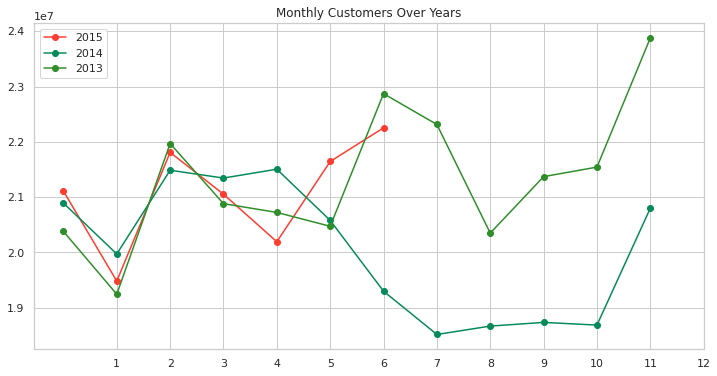

In [54]:
# unique year values in date
years = rossmann_df['Year'].unique().tolist()

num_of_colors = len(years)
list_of_colors = color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
                                                                       for j in range(num_of_colors)]
num = -1
plt.figure(figsize=(12, 6))
for year in years:
  num += 1
  temp_df = rossmann_df[rossmann_df['Year'] == year]
  temp_df = temp_df.groupby('Month')['Customers'].sum().reset_index()
  plt.plot(temp_df.loc[:,'Customers'], label=year, color=list_of_colors[num], marker='o')
  plt.xticks(range(1, 13))

plt.title('Monthly Customers Over Years')
plt.legend()

Sales and Customers are showing almost similar trends. Both dips during fall and peaks during the winter.

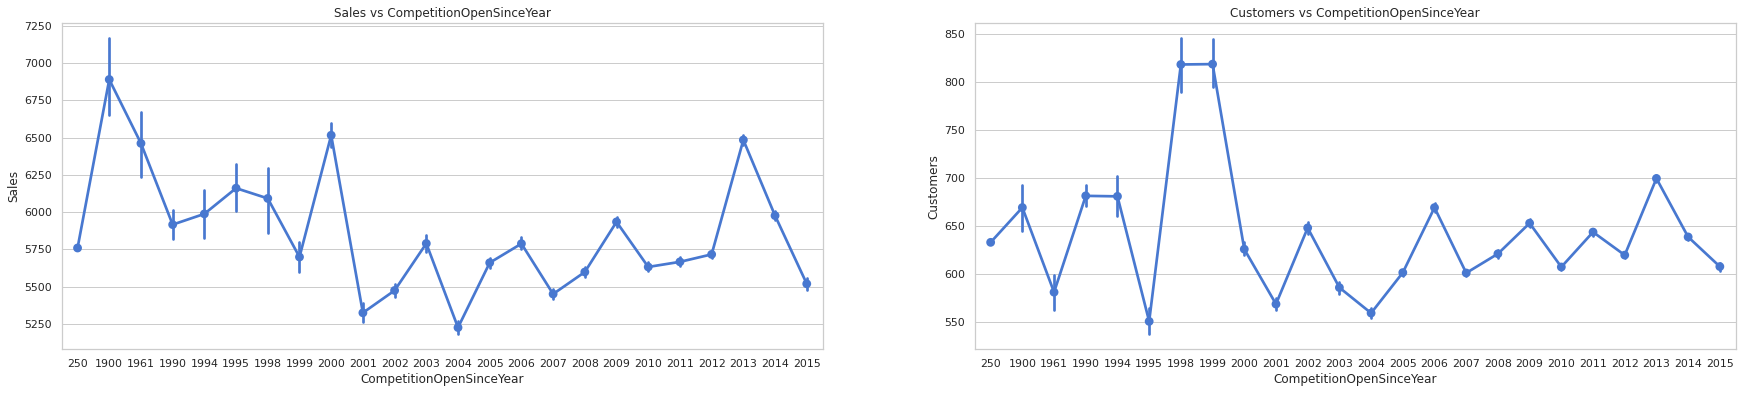

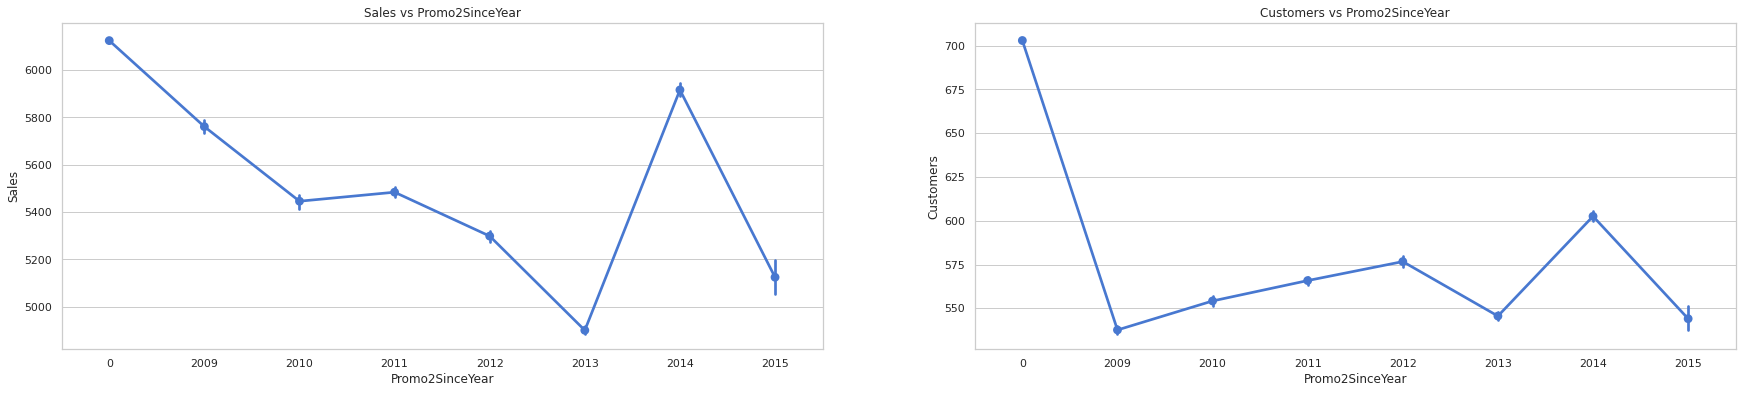

In [55]:
for feature in ('CompetitionOpenSinceYear', 'Promo2SinceYear'):
  fig, axes = plt.subplots(1, 2, figsize=(30,6))
  sns.pointplot(ax=axes[0], x=feature, y='Sales', data=rossmann_df)
  axes[0].set_title(f'Sales vs {feature}')
  sns.pointplot(ax=axes[1], x=feature, y='Customers', data=rossmann_df)
  axes[1].set_title(f'Customers vs {feature}')

Sales peaked at 1900 when a few stores were present so there was only a little competition. As years passed sales started to decline due to the increase in competition. But number of customers has peaked during late 1990s. Sales due to promo 2 is generally decreasing over the years, only exception in 2014.

Lets take a look at how Sales and customers change with competition distance.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (25, 6))
sns.scatterplot(ax=axes[0], x='CompetitionDistance', y='Sales', data=rossmann_df)
axes[0].set_title('Sales vs CompetitionDistance')
sns.scatterplot(ax=axes[1], x='CompetitionDistance', y='Customers', data=rossmann_df)
axes[1].set_title('Customers vs CompetitionDistance')
plt.show()

Sales and customers decreases with increase in competition distance.

## Conclusions from EDA

1. Mondays have most sales.
2. Promos are proved to be beneficial.
3. More Store type b has to be opened and more asortment b has be stocked to meet the demands of customers.
4. Competition is increasing and the effect of promo 2 is tends to be declining.
5. Sales are higher on school holidays than other days.

# Feature Engineering